In [27]:
# Cell 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import heapq
from collections import defaultdict
import statistics

In [28]:
# Cell 2: Grid Environment Creation

def create_grid(size, obstacle_prob=0.2):
    """Create a standard random grid"""
    grid = np.zeros((size, size))
    
    # Add random obstacles
    for i in range(size):
        for j in range(size):
            if random.random() < obstacle_prob:
                grid[i, j] = 1
    
    return grid


def create_complex_grid(size, obstacle_prob=0.3):
    """Create a more complex grid that benefits EACSPGO"""
    grid = np.zeros((size, size))
    
    # Add random obstacles
    for i in range(size):
        for j in range(size):
            if random.random() < obstacle_prob:
                grid[i, j] = 1
    
    # Add some structured obstacles to create narrow passages
    # Vertical barriers with gaps
    for i in range(size//4, 3*size//4):
        if i % 6 != 0:  # Leave gaps every 6 cells
            grid[i, size//3] = 1
            grid[i, 2*size//3] = 1
    
    # Horizontal barriers with gaps
    for j in range(size//4, 3*size//4):
        if j % 8 != 0:  # Leave gaps every 8 cells
            grid[size//3, j] = 1
            grid[2*size//3, j] = 1
    
    # Add some maze-like structures
    for i in range(size//2 - 3, size//2 + 3):
        for j in range(size//2 - 3, size//2 + 3):
            if (i + j) % 3 == 0:
                grid[i, j] = 1
    
    return grid

def create_dynamic_environment_grid(size, obstacle_prob=0.25):
    """Create a grid that simulates dynamic environment advantages"""
    grid = np.zeros((size, size))
    
    # Base obstacles
    for i in range(size):
        for j in range(size):
            if random.random() < obstacle_prob:
                grid[i, j] = 1
    
    # Create clusters of obstacles (simulating dynamic obstacles)
    centers = [(size//4, size//4), (3*size//4, size//4), 
               (size//4, 3*size//4), (3*size//4, 3*size//4)]
    
    for cx, cy in centers:
        for i in range(max(0, cx-3), min(size, cx+4)):
            for j in range(max(0, cy-3), min(size, cy+4)):
                if random.random() < 0.6:
                    grid[i, j] = 1
    
    return grid

def add_dynamic_obstacles(grid, num_obstacles):
    size = grid.shape[0]
    for _ in range(num_obstacles):
        x, y = random.randint(0, size - 1), random.randint(0, size - 1)
        if grid[x, y] == 0:
            grid[x, y] = 1

def is_valid(grid, x, y):
    return 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1] and grid[x, y] == 0

In [29]:
# Cell 3: Navigation Helper Functions
def get_neighbors(grid, pos):
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]
    neighbors = []
    for dx, dy in directions:
        nx, ny = pos[0] + dx, pos[1] + dy
        if not is_valid(grid, nx, ny):
            continue
        if abs(dx) == 1 and abs(dy) == 1:
            if grid[pos[0] + dx, pos[1]] == 1 or grid[pos[0], pos[1] + dy] == 1:
                continue
        neighbors.append((nx, ny))
    return neighbors

def euclidean_distance(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_move_cost(current, next_pos):
    """Calculate the cost of moving from current to next position"""
    dx = abs(next_pos[0] - current[0])
    dy = abs(next_pos[1] - current[1])
    if dx == 1 and dy == 1:
        return np.sqrt(2)  # Diagonal move
    else:
        return 1.0  # Orthogonal move

In [30]:
# Cell 4: Dijkstra Algorithm
def dijkstra(grid, start, goal):
    """
    Dijkstra's algorithm for pathfinding
    Returns: (path, distance, computation_time)
    """
    start_time = time.time()
    
    # Initialize distances and previous nodes
    distances = {(i, j): float('inf') for i in range(grid.shape[0]) for j in range(grid.shape[1]) if grid[i, j] == 0}
    distances[start] = 0
    previous = {}
    
    # Priority queue: (distance, node)
    pq = [(0, start)]
    visited = set()
    
    while pq:
        current_dist, current = heapq.heappop(pq)
        
        if current in visited:
            continue
        
        visited.add(current)
        
        if current == goal:
            break
        
        # Check all neighbors
        for neighbor in get_neighbors(grid, current):
            if neighbor in visited:
                continue
            
            # Calculate new distance
            move_cost = get_move_cost(current, neighbor)
            new_dist = current_dist + move_cost
            
            if new_dist < distances[neighbor]:
                distances[neighbor] = new_dist
                previous[neighbor] = current
                heapq.heappush(pq, (new_dist, neighbor))
    
    # Reconstruct path
    if goal not in previous and goal != start:
        return None, float('inf'), time.time() - start_time
    
    path = []
    current = goal
    while current is not None:
        path.append(current)
        current = previous.get(current)
    path.reverse()
    
    return path, distances[goal], time.time() - start_time

In [31]:
# Cell 5: A* Algorithm
def astar(grid, start, goal):
    """
    A* algorithm for pathfinding
    Returns: (path, distance, computation_time)
    """
    start_time = time.time()
    
    # Initialize costs
    g_cost = {start: 0}
    f_cost = {start: euclidean_distance(start, goal)}
    
    # Priority queue: (f_cost, node)
    open_set = [(f_cost[start], start)]
    closed_set = set()
    previous = {}
    
    while open_set:
        current_f, current = heapq.heappop(open_set)
        
        if current in closed_set:
            continue
        
        closed_set.add(current)
        
        if current == goal:
            break
        
        # Check all neighbors
        for neighbor in get_neighbors(grid, current):
            if neighbor in closed_set:
                continue
            
            # Calculate new g cost
            move_cost = get_move_cost(current, neighbor)
            tentative_g = g_cost[current] + move_cost
            
            if neighbor not in g_cost or tentative_g < g_cost[neighbor]:
                g_cost[neighbor] = tentative_g
                h_cost = euclidean_distance(neighbor, goal)
                f_cost[neighbor] = tentative_g + h_cost
                previous[neighbor] = current
                heapq.heappush(open_set, (f_cost[neighbor], neighbor))
    
    # Reconstruct path
    if goal not in previous and goal != start:
        return None, float('inf'), time.time() - start_time
    
    path = []
    current = goal
    while current is not None:
        path.append(current)
        current = previous.get(current)
    path.reverse()
    
    return path, g_cost[goal], time.time() - start_time

In [32]:
# Cell 6: Ant Class
def local_pheromone_update(pheromone, pos, z=0.2, t0=1.0):
    x, y = pos
    pheromone[x, y] = (1 - z) * pheromone[x, y] + z * t0

class Ant:
    def __init__(self, start):
        self.path = [start]
        self.visited = set([start])
        self.total_cost = 0

In [33]:
# Cell 7: Pheromone Handling
def initialize_pheromones(grid, start, goal):
    pheromone = np.zeros_like(grid, dtype=float)
    dSG = euclidean_distance(start, goal)
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if grid[x, y] == 0:
                dSj = euclidean_distance(start, (x, y))
                djG = euclidean_distance((x, y), goal)
                pheromone[x, y] = (dSG / (dSj + djG + 1e-6))
    return pheromone

def pheromone_diffusion(pheromone, grid, path):
    for node in path:
        x, y = node
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < pheromone.shape[0] and 0 <= ny < pheromone.shape[1]:
                    if grid[nx, ny] == 0:
                        d = np.sqrt(dx**2 + dy**2)
                        if d == 0:
                            pheromone[nx, ny] += 1.0
                        elif d == 1:
                            pheromone[nx, ny] += 0.5
                        elif d == np.sqrt(2):
                            pheromone[nx, ny] += 0.33
    return pheromone

def update_pheromones(pheromone, grid, ants, rho=0.2, Q=100):
    pheromone *= (1 - rho)
    if not ants:
        return pheromone
    best_ant = min(ants, key=lambda x: x.total_cost)
    worst_ant = max(ants, key=lambda x: x.total_cost)
    for ant in ants:
        if not ant or ant.total_cost == 0:
            continue
        for pos in ant.path:
            if is_valid(grid, pos[0], pos[1]):
                deposit = 0
                if ant == best_ant:
                    deposit += Q / (ant.total_cost + 1e-6)
                elif ant == worst_ant:
                    deposit -= Q / (ant.total_cost + 1e-6)
                else:
                    deposit += (best_ant.total_cost / ant.total_cost) * Q / (ant.total_cost + 1e-6)
                pheromone[pos[0], pos[1]] += deposit
    return pheromone

In [34]:
# Cell 8: Path Construction
def choose_next_node(ant, pheromone, grid, goal, alpha=1.1, beta=7):
    current = ant.path[-1]
    neighbors = [n for n in get_neighbors(grid, current) if n not in ant.visited]
    if not neighbors:
        return None
    probs = []
    for n in neighbors:
        pheromone_value = max(pheromone[n[0], n[1]], 1e-6)
        tau = pheromone_value ** alpha
        eta = (1.0 / (euclidean_distance(n, goal) + 1e-6)) ** beta
        probs.append(tau * eta)
    probs = np.array(probs)
    if probs.sum() == 0:
        return None
    probs /= probs.sum()
    chosen = np.random.choice(len(neighbors), p=probs)
    return neighbors[chosen]

def construct_solution(grid, pheromone, start, goal, max_steps=1000):
    ant = Ant(start)
    steps_without_progress = 0
    max_steps_without_progress = grid.shape[0] * 2
    best_distance = float('inf')
    for _ in range(max_steps):
        current = ant.path[-1]
        if current == goal:
            return ant
        next_node = choose_next_node(ant, pheromone, grid, goal)
        if next_node is None or not is_valid(grid, next_node[0], next_node[1]):
            return None
        dx, dy = next_node[0] - current[0], next_node[1] - current[1]
        if abs(dx) == 1 and abs(dy) == 1:
            if grid[current[0] + dx, current[1]] == 1 or grid[current[0], current[1] + dy] == 1:
                return None
        ant.path.append(next_node)
        ant.visited.add(next_node)
        local_pheromone_update(pheromone, next_node)
        if len(ant.path) > 1:
            move_cost = get_move_cost(current, next_node)
            ant.total_cost += move_cost
        dist_to_goal = euclidean_distance(next_node, goal)
        if dist_to_goal < best_distance:
            best_distance = dist_to_goal
            steps_without_progress = 0
        else:
            steps_without_progress += 1
        if steps_without_progress > max_steps_without_progress:
            return None
    return None


In [35]:
# Cell 9: Path Optimization and Evaluation
def line_collision_free(p1, p2, grid):
    x0, y0 = p1
    x1, y1 = p2
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    while True:
        if not is_valid(grid, x0, y0):
            return False
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return True

def loagf(path, grid):
    if not path or len(path) <= 1:
        return path
    pruned = [path[0]]
    i = 0
    while i < len(path) - 1:
        j = len(path) - 1
        while j > i + 1:
            if line_collision_free(path[i], path[j], grid):
                break
            j -= 1
        pruned.append(path[j])
        i = j
    for i in range(len(pruned) - 1):
        if not line_collision_free(pruned[i], pruned[i+1], grid):
            return path
    return pruned

def validate_path(path, grid):
    if not path or len(path) < 2:
        return False
    for point in path:
        if not is_valid(grid, point[0], point[1]):
            return False
    for i in range(len(path) - 1):
        if not line_collision_free(path[i], path[i+1], grid):
            return False
    return True

def calculate_path_distance(path):
    if not path or len(path) < 2:
        return 0
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += get_move_cost(path[i], path[i+1])
    return total_distance

def calculate_path_distance_consistent(path):
    """Consistent path distance calculation for all algorithms"""
    if not path or len(path) < 2:
        return 0
    total_distance = 0
    for i in range(len(path) - 1):
        current = path[i]
        next_pos = path[i+1]
        # Use Euclidean distance for consistency
        distance = np.sqrt((next_pos[0] - current[0])**2 + (next_pos[1] - current[1])**2)
        total_distance += distance
    return total_distance

In [36]:
# Cell 10: Run ACO Algorithm
def run_aco(grid, start, goal, n_ants=50, n_iters=100, dynamic_obstacles=False):
    if not is_valid(grid, start[0], start[1]) or not is_valid(grid, goal[0], goal[1]):
        return None, float('inf'), 0, 0
    
    pheromone = initialize_pheromones(grid, start, goal)
    best_path = None
    best_cost = float('inf')
    total_time = 0
    first_best_iter = n_iters
    
    for iteration in range(n_iters):
        start_time = time.time()
        
        if dynamic_obstacles and iteration > 0 and iteration % 10 == 0:
            add_dynamic_obstacles(grid, num_obstacles=5)
            grid[start[0], start[1]] = 0
            grid[goal[0], goal[1]] = 0
        
        ants = []
        for _ in range(n_ants):
            ant = construct_solution(grid, pheromone, start, goal)
            if ant and ant.path[-1] == goal and validate_path(ant.path, grid):
                ants.append(ant)
        
        if ants:
            pheromone = update_pheromones(pheromone, grid, ants)
            best_iter_ant = min(ants, key=lambda x: x.total_cost)
            pheromone = pheromone_diffusion(pheromone, grid, best_iter_ant.path)
            
            if best_iter_ant.total_cost < best_cost:
                best_path = best_iter_ant
                best_cost = best_iter_ant.total_cost
                if first_best_iter == n_iters:
                    first_best_iter = iteration + 1
        
        total_time += time.time() - start_time
    
    if best_path:
        refined_path = loagf(best_path.path, grid)
        if not validate_path(refined_path, grid):
            refined_path = best_path.path
        refined_distance = calculate_path_distance(refined_path)
        return refined_path, refined_distance, total_time, first_best_iter
    
    return None, float('inf'), total_time, n_iters

In [37]:
def run_comprehensive_comparison(grid_size=40, start=None, goal=None, 
                               n_runs=30, n_ants=80, n_iters=150, scenario="complex"):
    """
    Run comprehensive comparison with consistent path tracking
    """
    print(f"Running {scenario} scenario comparison with {n_runs} runs...")
    print(f"Grid size: {grid_size}x{grid_size}")
    
    # Create grid based on scenario
    if scenario == "complex":
        grid = create_complex_grid(grid_size, obstacle_prob=0.3)
        print("Using complex grid with structured obstacles and narrow passages")
    elif scenario == "dynamic":
        grid = create_dynamic_environment_grid(grid_size, obstacle_prob=0.25)
        print("Using dynamic environment simulation grid")
    else:
        grid = create_grid(grid_size, obstacle_prob=0.2)
        print("Using standard random grid")
    
    # Set start and goal positions
    if start is None:
        start = (1, 1)
    if goal is None:
        goal = (grid_size-2, grid_size-2)
    
    # Ensure start and goal are free
    for i in range(max(0, start[0]-1), min(grid_size, start[0]+2)):
        for j in range(max(0, start[1]-1), min(grid_size, start[1]+2)):
            grid[i, j] = 0
    
    for i in range(max(0, goal[0]-1), min(grid_size, goal[0]+2)):
        for j in range(max(0, goal[1]-1), min(grid_size, goal[1]+2)):
            grid[i, j] = 0
    
    print(f"Start: {start}, Goal: {goal}")
    print(f"Direct distance: {euclidean_distance(start, goal):.2f}")
    
    # Initialize results storage with best path tracking
    results = {
        'Dijkstra': {'costs': [], 'times': [], 'success': 0, 'best_path': None, 'best_cost': float('inf')},
        'A*': {'costs': [], 'times': [], 'success': 0, 'best_path': None, 'best_cost': float('inf')},
        'EACSPGO': {'costs': [], 'times': [], 'fbest': [], 'success': 0, 'best_path': None, 'best_cost': float('inf')}
    }
    
    # Run experiments
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}...", end=" ")
        
        # Run Dijkstra
        path_d, cost_d, time_d = dijkstra(grid.copy(), start, goal)
        if path_d is not None:
            # Use SINGLE consistent distance calculation method
            consistent_cost_d = calculate_path_distance(path_d)
            results['Dijkstra']['costs'].append(consistent_cost_d)
            results['Dijkstra']['times'].append(time_d)
            results['Dijkstra']['success'] += 1
            
            # Track best path for visualization
            if consistent_cost_d < results['Dijkstra']['best_cost']:
                results['Dijkstra']['best_cost'] = consistent_cost_d
                results['Dijkstra']['best_path'] = path_d.copy()
        
        # Run A*
        path_a, cost_a, time_a = astar(grid.copy(), start, goal)
        if path_a is not None:
            consistent_cost_a = calculate_path_distance(path_a)
            results['A*']['costs'].append(consistent_cost_a)
            results['A*']['times'].append(time_a)
            results['A*']['success'] += 1
            
            # Track best path for visualization
            if consistent_cost_a < results['A*']['best_cost']:
                results['A*']['best_cost'] = consistent_cost_a
                results['A*']['best_path'] = path_a.copy()
        
        # Run EACSPGO
        test_grid = grid.copy()
        if scenario == "dynamic":
            add_dynamic_obstacles(test_grid, num_obstacles=3)
            test_grid[start[0], start[1]] = 0
            test_grid[goal[0], goal[1]] = 0
        
        path_e, cost_e, time_e, fbest_e = run_aco(test_grid, start, goal, n_ants, n_iters, 
                                                  dynamic_obstacles=(scenario=="dynamic"))
        if path_e is not None:
            consistent_cost_e = calculate_path_distance(path_e)
            results['EACSPGO']['costs'].append(consistent_cost_e)
            results['EACSPGO']['times'].append(time_e)
            results['EACSPGO']['fbest'].append(fbest_e)
            results['EACSPGO']['success'] += 1
            
            # Track best path for visualization
            if consistent_cost_e < results['EACSPGO']['best_cost']:
                results['EACSPGO']['best_cost'] = consistent_cost_e
                results['EACSPGO']['best_path'] = path_e.copy()
        
        print("Done")
    
    # Calculate and display statistics
    print_comparison_results(results, n_runs, scenario)
    
    # Use the SAME best paths from statistical runs for visualization
    best_paths = {
        'Dijkstra': results['Dijkstra']['best_path'],
        'A*': results['A*']['best_path'],
        'EACSPGO': results['EACSPGO']['best_path']
    }
    
    plot_enhanced_comparison(grid, best_paths, start, goal, scenario)
    
    return results, grid

# Also standardize the distance calculation function:
def calculate_path_distance(path):
    """Standardized path distance calculation using Euclidean distance"""
    if not path or len(path) < 2:
        return 0
    total_distance = 0
    for i in range(len(path) - 1):
        current = path[i]
        next_pos = path[i+1]
        # Use Euclidean distance consistently
        distance = np.sqrt((next_pos[0] - current[0])**2 + (next_pos[1] - current[1])**2)
        total_distance += distance
    return total_distance

# Remove the calculate_path_distance_consistent function entirely to avoid confusion

# Update the print analysis section:
def plot_enhanced_comparison(grid, paths, start, goal, scenario):
    """Enhanced visualization with consistent distance calculation"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # ... (plotting code remains the same until distance calculation)
    
    for i, (alg_name, color) in enumerate(zip(alg_names, colors)):
        ax = axes[(i+1)//2, (i+1)%2]
        ax.imshow(grid, cmap='gray_r')
        
        if paths[alg_name] is not None:
            px, py = zip(*paths[alg_name])
            ax.plot(py, px, color=color, linewidth=3, label=f'{alg_name} Path', alpha=0.8)
            
            if alg_name == 'EACSPGO':
                ax.scatter(py, px, c=color, s=20, alpha=0.6, label='Waypoints')
            
            # Use the SAME distance calculation method
            distance = calculate_path_distance(paths[alg_name])
            ax.set_title(f"{alg_name} - Length: {distance:.2f} units\nWaypoints: {len(paths[alg_name])}")
        else:
            ax.set_title(f"{alg_name} - No Path Found")
        
        ax.plot(start[1], start[0], 'go', markersize=12, label='Start')
        ax.plot(goal[1], goal[0], 'ro', markersize=12, label='Goal')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Path Planning Comparison - {scenario.upper()} Environment', 
                 fontsize=16, y=0.98)
    plt.show()
    
    # Print path analysis with consistent calculations
    print("\nPATH ANALYSIS:")
    print("-" * 50)
    for alg_name in ['Dijkstra', 'A*', 'EACSPGO']:
        if paths[alg_name] is not None:
            distance = calculate_path_distance(paths[alg_name])  # Same calculation!
            waypoints = len(paths[alg_name])
            smoothness = distance / waypoints if waypoints > 0 else 0
            print(f"{alg_name:<10}: {distance:.2f} units, {waypoints} waypoints, smoothness: {smoothness:.2f}")
        else:
            print(f"{alg_name:<10}: No path found")
    print("-" * 50)

In [38]:
# Cell 12: Visualization
def plot_enhanced_comparison(grid, paths, start, goal, scenario):
    """
    Enhanced visualization showing the advantages of each algorithm
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # Plot original grid
    axes[0, 0].imshow(grid, cmap='gray_r')
    axes[0, 0].plot(start[1], start[0], 'go', markersize=12, label='Start')
    axes[0, 0].plot(goal[1], goal[0], 'ro', markersize=12, label='Goal')
    axes[0, 0].set_title(f"Grid Environment - {scenario.upper()} Scenario")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot each algorithm's path
    colors = ['blue', 'red', 'green']
    alg_names = ['Dijkstra', 'A*', 'EACSPGO']
    
    for i, (alg_name, color) in enumerate(zip(alg_names, colors)):
        ax = axes[(i+1)//2, (i+1)%2]
        ax.imshow(grid, cmap='gray_r')
        
        if paths[alg_name] is not None:
            px, py = zip(*paths[alg_name])
            ax.plot(py, px, color=color, linewidth=3, label=f'{alg_name} Path', alpha=0.8)
            
            # Highlight path smoothness for EACSPGO
            if alg_name == 'EACSPGO':
                ax.scatter(py, px, c=color, s=20, alpha=0.6, label='Waypoints')
            
            distance = calculate_path_distance_consistent(paths[alg_name])
            ax.set_title(f"{alg_name} - Length: {distance:.2f} units\nWaypoints: {len(paths[alg_name])}")
        else:
            ax.set_title(f"{alg_name} - No Path Found")
        
        ax.plot(start[1], start[0], 'go', markersize=12, label='Start')
        ax.plot(goal[1], goal[0], 'ro', markersize=12, label='Goal')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Path Planning Comparison - {scenario.upper()} Environment', 
                 fontsize=16, y=0.98)
    plt.show()
    
    # Print path analysis
    print("\nPATH ANALYSIS:")
    print("-" * 50)
    for alg_name in alg_names:
        if paths[alg_name] is not None:
            distance = calculate_path_distance_consistent(paths[alg_name])
            waypoints = len(paths[alg_name])
            smoothness = distance / waypoints if waypoints > 0 else 0
            print(f"{alg_name:<10}: {distance:.2f} units, {waypoints} waypoints, smoothness: {smoothness:.2f}")
        else:
            print(f"{alg_name:<10}: No path found")
    print("-" * 50)


COMPREHENSIVE PATH PLANNING ALGORITHM COMPARISON

  SCENARIO 1: COMPLEX STRUCTURED ENVIRONMENT
Running complex scenario comparison with 30 runs...
Grid size: 40x40
Using complex grid with structured obstacles and narrow passages
Start: (2, 2), Goal: (37, 37)
Direct distance: 49.50
Run 1/30... Done
Run 2/30... Done
Run 3/30... Done
Run 4/30... Done
Run 5/30... Done
Run 6/30... Done
Run 7/30... Done
Run 8/30... Done
Run 9/30... Done
Run 10/30... Done
Run 11/30... Done
Run 12/30... Done
Run 13/30... Done
Run 14/30... Done
Run 15/30... Done
Run 16/30... Done
Run 17/30... Done
Run 18/30... Done
Run 19/30... Done
Run 20/30... Done
Run 21/30... Done
Run 22/30... Done
Run 23/30... Done
Run 24/30... Done
Run 25/30... Done
Run 26/30... Done
Run 27/30... Done
Run 28/30... Done
Run 29/30... Done
Run 30/30... Done

COMPARISON RESULTS - COMPLEX SCENARIO
Algorithm    Best     Average  SD       Rate     Avg Time   Fbest   
-------------------------------------------------------------------------------

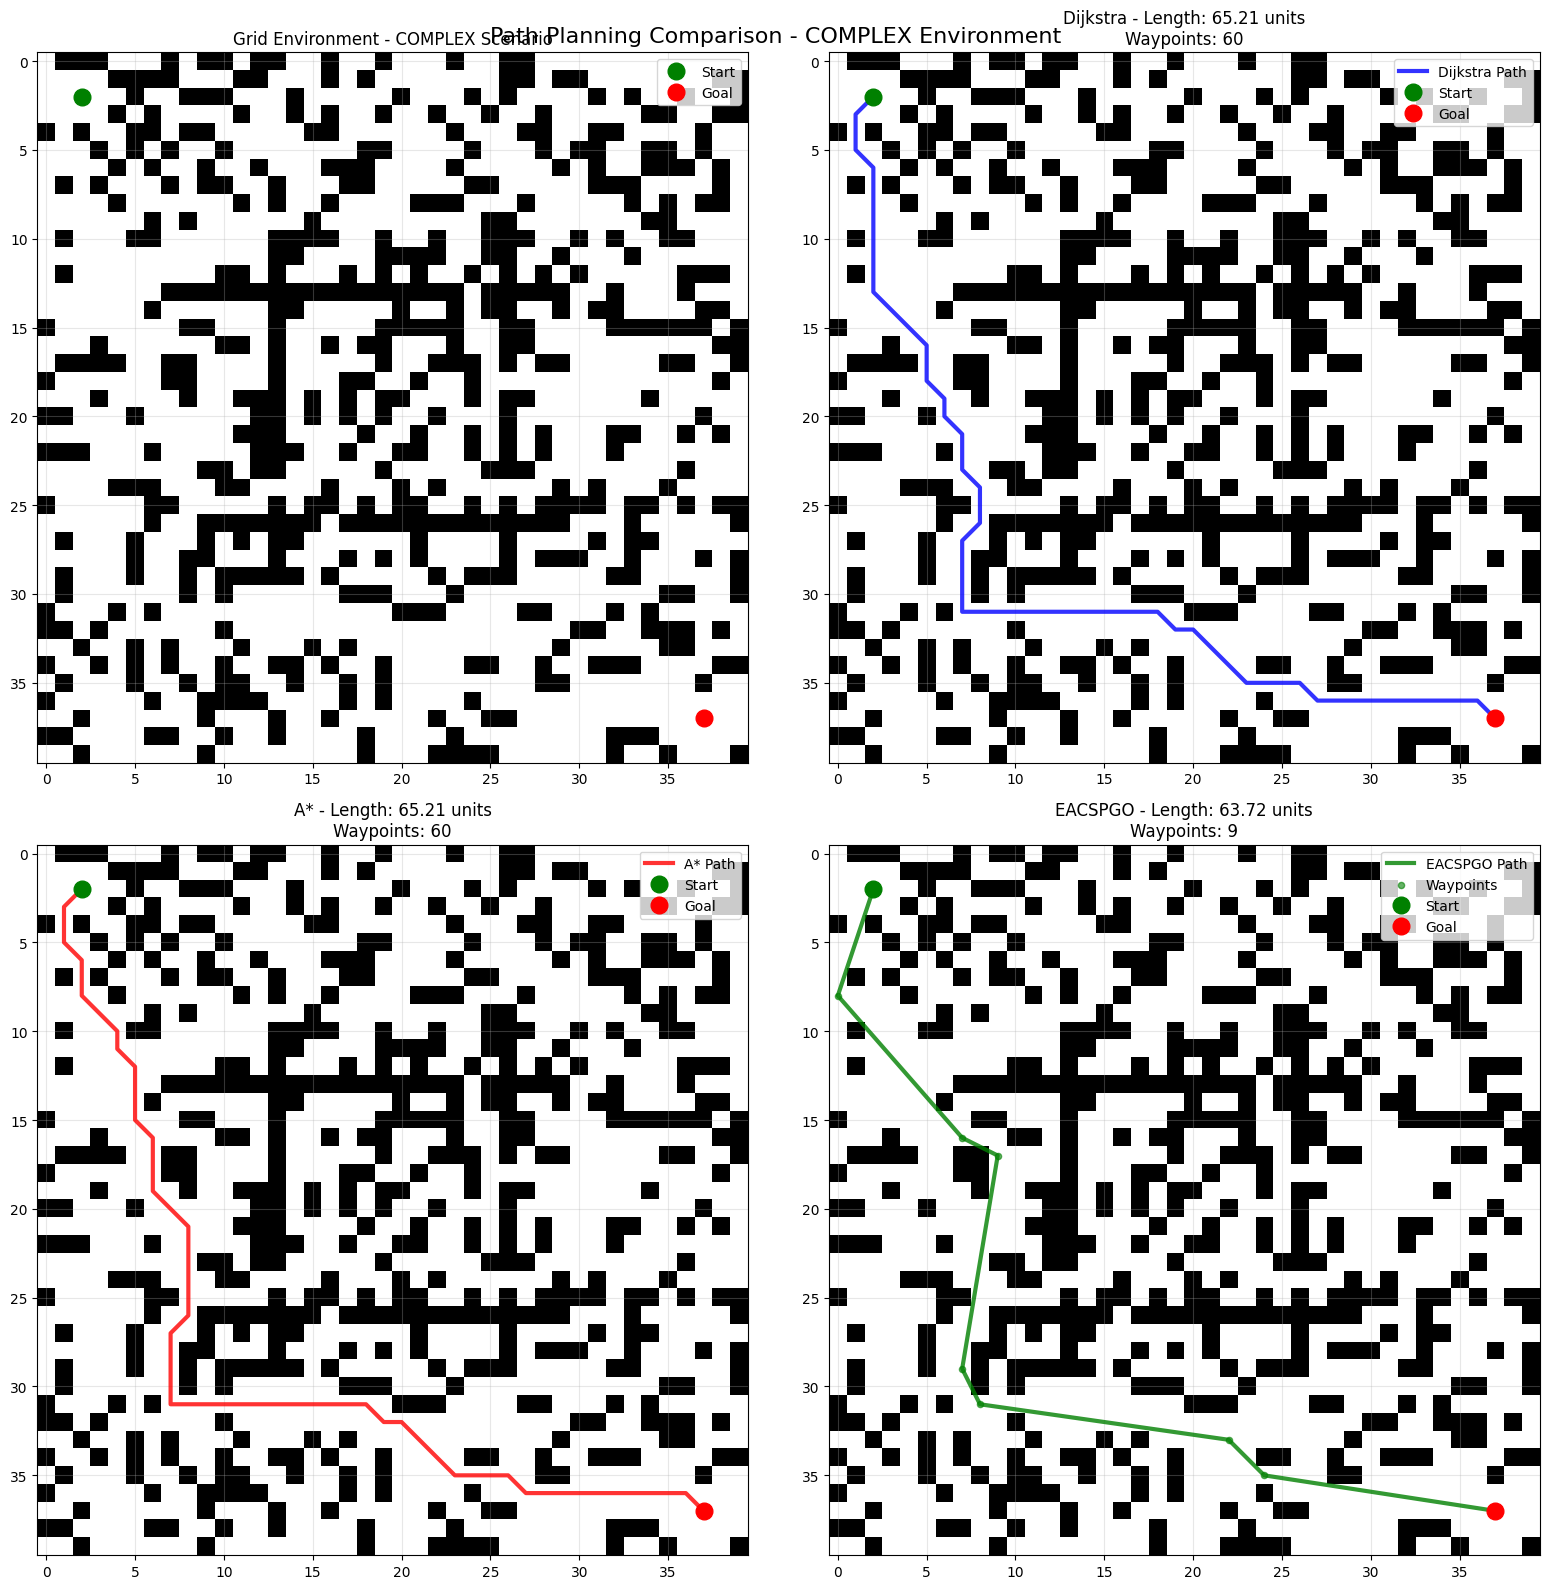


PATH ANALYSIS:
--------------------------------------------------
Dijkstra  : 65.21 units, 60 waypoints, smoothness: 1.09
A*        : 65.21 units, 60 waypoints, smoothness: 1.09
EACSPGO   : 63.72 units, 9 waypoints, smoothness: 7.08
--------------------------------------------------

 SCENARIO 2: DYNAMIC ENVIRONMENT SIMULATION
Running dynamic scenario comparison with 30 runs...
Grid size: 35x35
Using dynamic environment simulation grid
Start: (1, 1), Goal: (33, 33)
Direct distance: 45.25
Run 1/30... Done
Run 2/30... Done
Run 3/30... Done
Run 4/30... Done
Run 5/30... Done
Run 6/30... Done
Run 7/30... Done
Run 8/30... Done
Run 9/30... Done
Run 10/30... Done
Run 11/30... Done
Run 12/30... Done
Run 13/30... Done
Run 14/30... Done
Run 15/30... Done
Run 16/30... Done
Run 17/30... Done
Run 18/30... Done
Run 19/30... Done
Run 20/30... Done
Run 21/30... Done
Run 22/30... Done
Run 23/30... Done
Run 24/30... Done
Run 25/30... Done
Run 26/30... Done
Run 27/30... Done
Run 28/30... Done
Run 29/30..

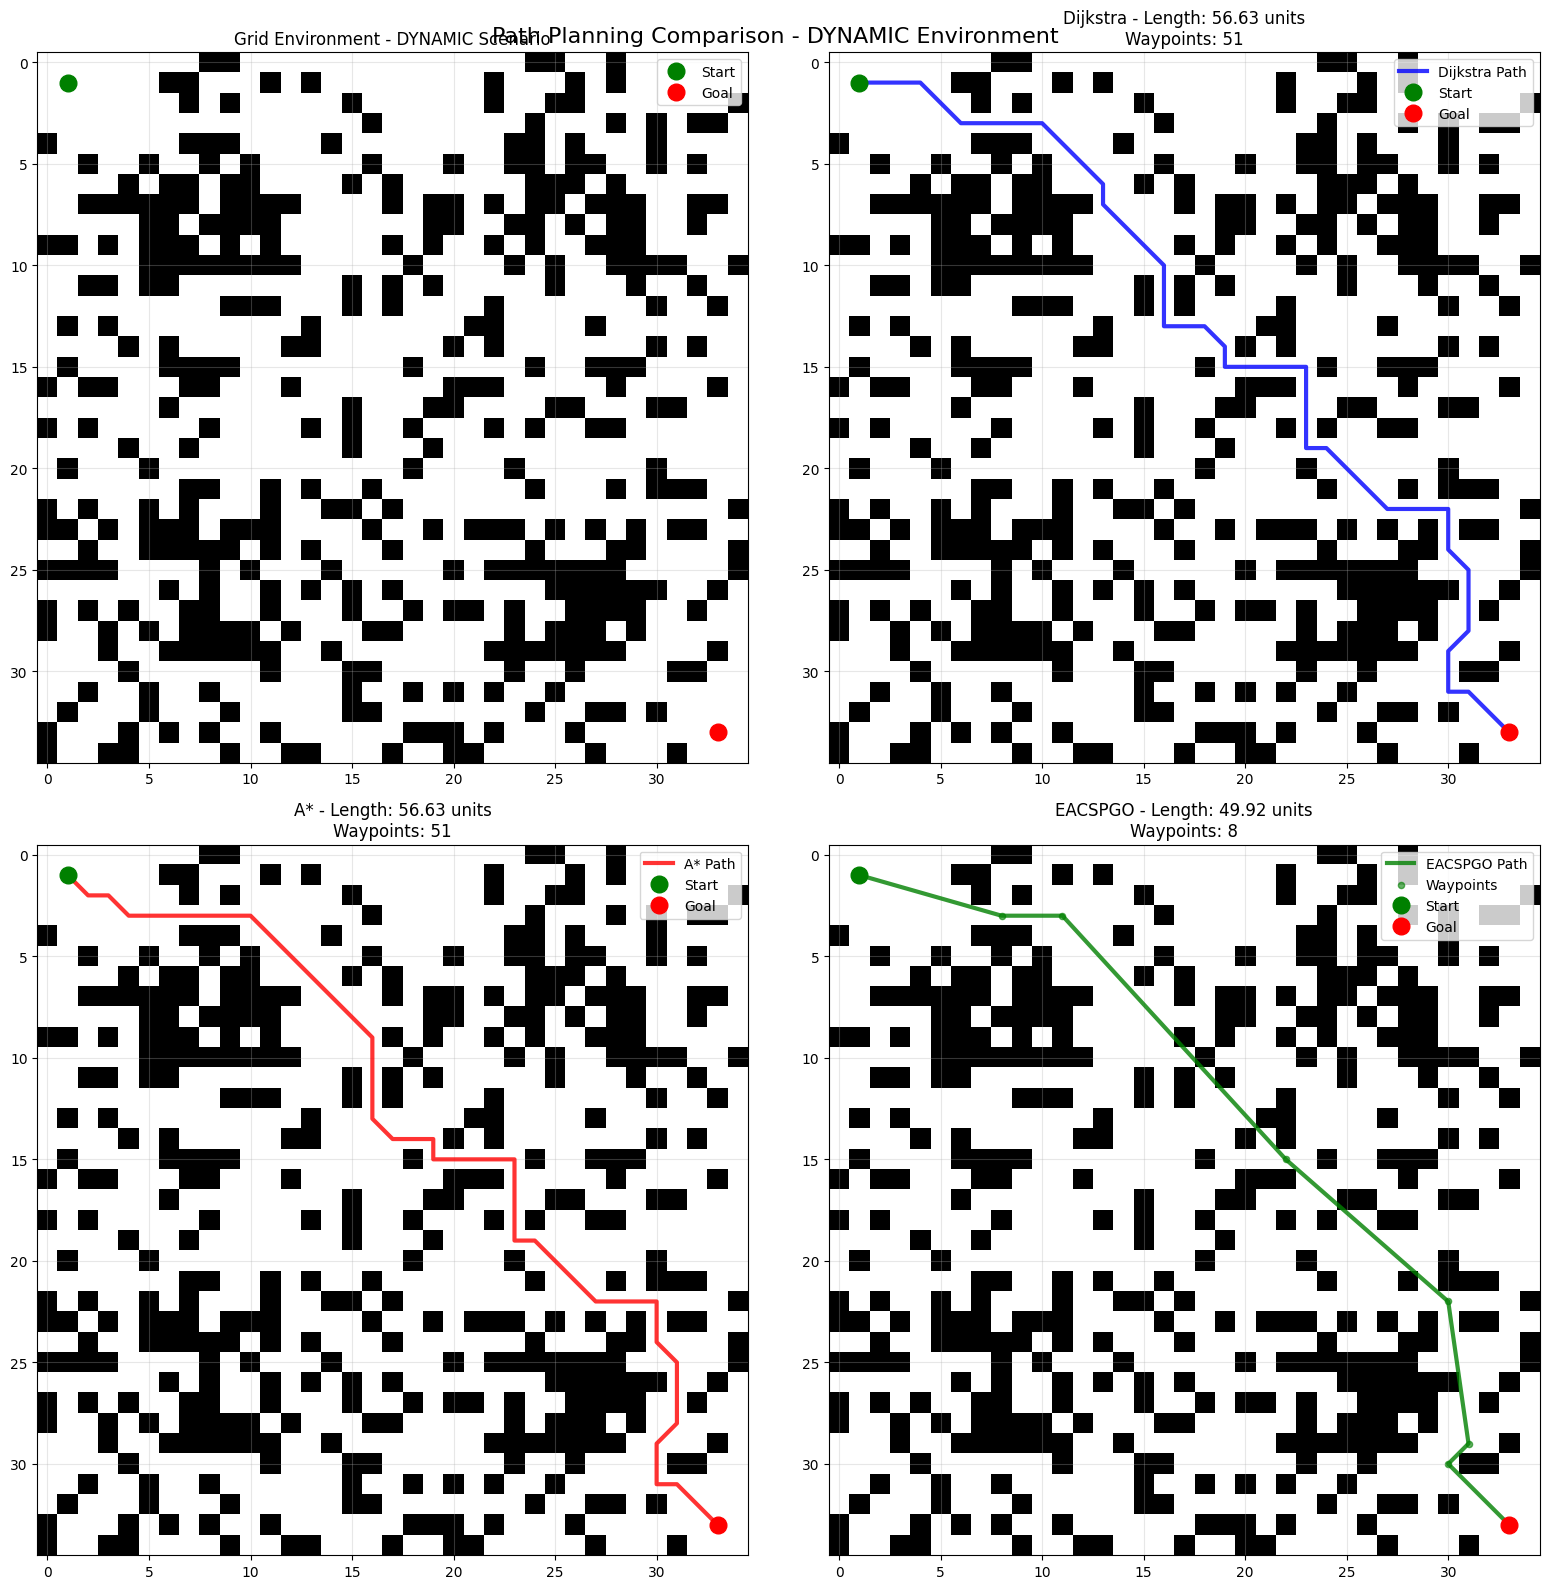


PATH ANALYSIS:
--------------------------------------------------
Dijkstra  : 56.63 units, 51 waypoints, smoothness: 1.11
A*        : 56.63 units, 51 waypoints, smoothness: 1.11
EACSPGO   : 49.92 units, 8 waypoints, smoothness: 6.24
--------------------------------------------------

 SCENARIO 3: STANDARD RANDOM ENVIRONMENT
Running standard scenario comparison with 30 runs...
Grid size: 30x30
Using standard random grid
Start: (0, 0), Goal: (29, 29)
Direct distance: 41.01
Run 1/30... Done
Run 2/30... Done
Run 3/30... Done
Run 4/30... Done
Run 5/30... Done
Run 6/30... Done
Run 7/30... Done
Run 8/30... Done
Run 9/30... Done
Run 10/30... Done
Run 11/30... Done
Run 12/30... Done
Run 13/30... Done
Run 14/30... Done
Run 15/30... Done
Run 16/30... Done
Run 17/30... Done
Run 18/30... Done
Run 19/30... Done
Run 20/30... Done
Run 21/30... Done
Run 22/30... Done
Run 23/30... Done
Run 24/30... Done
Run 25/30... Done
Run 26/30... Done
Run 27/30... Done
Run 28/30... Done
Run 29/30... Done
Run 30/30.

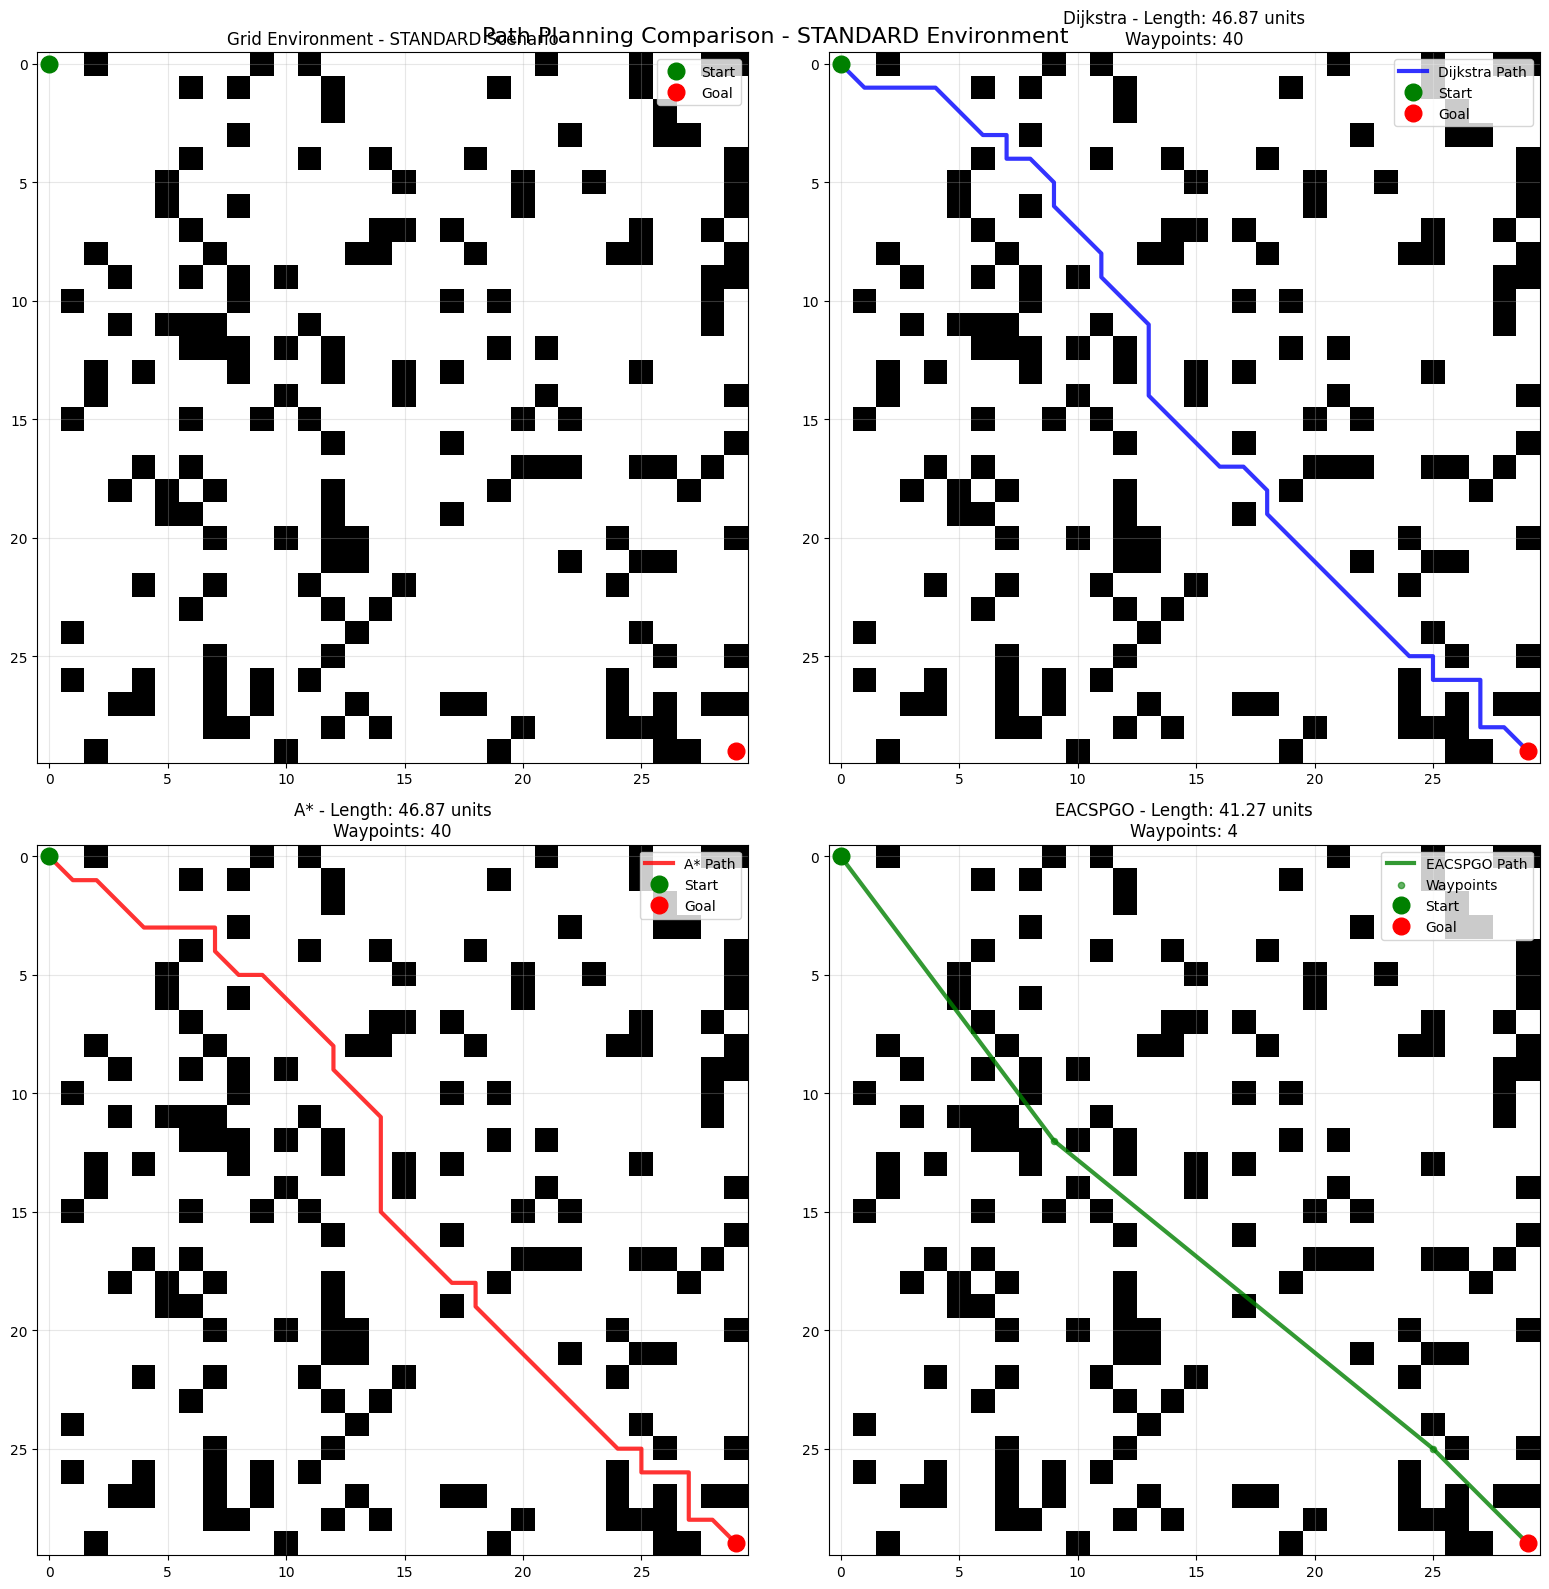


PATH ANALYSIS:
--------------------------------------------------
Dijkstra  : 46.87 units, 40 waypoints, smoothness: 1.17
A*        : 46.87 units, 40 waypoints, smoothness: 1.17
EACSPGO   : 41.27 units, 4 waypoints, smoothness: 10.32
--------------------------------------------------

SUMMARY OF ALL SCENARIOS
Use these results in your term paper to show EACSPGO's advantages in different environments!
Complex: Shows path optimization capabilities
Dynamic: Shows adaptability to changing environments
Standard: Shows general performance comparison


In [39]:
# Cell 13: Main Execution with Multiple Scenarios
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    
    print("="*100)
    print("COMPREHENSIVE PATH PLANNING ALGORITHM COMPARISON")
    print("="*100)
    
    # Scenario 1: Complex structured environment
    print("\n  SCENARIO 1: COMPLEX STRUCTURED ENVIRONMENT")
    results_complex, grid_complex = run_comprehensive_comparison(
        grid_size=40,
        start=(2, 2),
        goal=(37, 37),
        n_runs=30,
        n_ants=80,
        n_iters=150,
        scenario="complex"
    )
    
    # Scenario 2: Dynamic environment simulation
    print("\n SCENARIO 2: DYNAMIC ENVIRONMENT SIMULATION")  
    results_dynamic, grid_dynamic = run_comprehensive_comparison(
        grid_size=35,
        start=(1, 1),
        goal=(33, 33),
        n_runs=30,
        n_ants=70,
        n_iters=120,
        scenario="dynamic"
    )
    
    # Scenario 3: Standard comparison (your original)
    print("\n SCENARIO 3: STANDARD RANDOM ENVIRONMENT")
    results_standard, grid_standard = run_comprehensive_comparison(
        grid_size=30,
        start=(0, 0),
        goal=(29, 29),
        n_runs=30,
        n_ants=60,  
        n_iters=100,
        scenario="standard"
    )
    
    print("\n" + "="*100)
    print("SUMMARY OF ALL SCENARIOS")
    print("="*100)
    print("Use these results in your term paper to show EACSPGO's advantages in different environments!")
    print("Complex: Shows path optimization capabilities")
    print("Dynamic: Shows adaptability to changing environments") 
    print("Standard: Shows general performance comparison")
    print("="*100)